# GraphAttentionCNN for pytorch
###### for ABIDE study, by Hyeokjin Kwon

### 0 . Import the modules / Define the network

In [1]:
import os, sys
import math
import pandas as pd
import smogn
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.metrics import mean_absolute_error as mae
import torch
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.utils.data.dataset
from scipy.stats import pearsonr
from scipy.stats import rankdata
import copy
from sqrtm import sqrtm

from MachineLearningLibraryHyeokjin import *
from FunctionalNetworkLibraryHyeokjin import *
use_cuda = torch.cuda.is_available()

class E2EBlock(torch.nn.Module):
    '''E2Eblock.'''

    def __init__(self, in_planes, planes,example,bias=False):
        super(E2EBlock, self).__init__()
        self.d = example.size(3)
        self.cnn1 = torch.nn.Conv2d(in_planes,planes,(1,self.d),bias=bias)
        torch.nn.init.kaiming_normal_(self.cnn1.weight)
        self.cnn2 = torch.nn.Conv2d(in_planes,planes,(self.d,1),bias=bias)
        torch.nn.init.kaiming_normal_(self.cnn2.weight)
        
    def forward(self, x):
        a = self.cnn1(x)
        b = self.cnn2(x)
        return torch.cat([a]*self.d,3)+torch.cat([b]*self.d,2)

# Normalizing the adjacency matrix by a degree matrix
def norm_g(g):
    degrees = torch.sum(g, 1)
    g = g / degrees
    return g

# GCN model for batch graph data
# H1 = act( norm(G)*H0*W )
class batchedGCN(torch.nn.Module):
    def __init__(self, in_planes, planes):
        super(batchedGCN,self).__init__()
        # W
        self.proj = torch.nn.Linear(in_planes, planes)
        
    def forward(self,h,g):
        # h&g - batch x channel x node x node 
        h_ones, g_ones = torch.split(h,1,dim=0),torch.split(g,1,dim=0)
        o_hs = []
        for batch in range(len(h_ones)):
            # h_one&g_one - node x node
            h_one, g_one = h_ones[batch].squeeze(0).squeeze(0),g_ones[batch].squeeze(0).squeeze(0)
            
            # preprocessing : g_one
            g_one = (g_one > 0).float() # binarization
            g = norm_g(g_one) # normalization
            
            # calculate : norm(G)*H0*W
            h = torch.matmul(g,h_one)
            h = self.proj(h)
            o_hs.append(h)
            
        hs = torch.stack(o_hs,0).unsqueeze(1) # stack along the batch & add the channel
        
        return hs

# top-k pooling using the attention score
class top_k_pool(torch.nn.Module):
    def __init__(self, k):
        super(top_k_pool,self).__init__()
        # Nodes which have an upper k score will be survived
        self.k = k
        
    def forward(self,h,g,scores):
        # h&g - batch x channel x node x node 
        # score - batch x 1 x node x 1
        h_ones, g_ones, score_ones = torch.split(h,1,dim=0),torch.split(g,1,dim=0),torch.split(scores,1,dim=0)
        h_pool,g_pool,score_pool = [],[],[]
        for batch in range(len(h_ones)):
            # h_one&g_one - node x node
            h_one, g_one = h_ones[batch].squeeze(0).squeeze(0),g_ones[batch].squeeze(0).squeeze(0)
            
            # score - node x 1
            score = score_ones[batch].squeeze(0).squeeze(0)
            values, idx = torch.topk(score.squeeze(),self.k,dim=0)
            
            # top-k selection
            new_h = h_one[idx,:] # k x channel
            new_g = g_one[idx,:] 
            new_g = new_g[:,idx] # k x k
            new_score = score[idx] # k x 1
            
            h_pool.append(new_h)
            g_pool.append(new_g)
            score_pool.append(new_score)
        
        # stack along the batch & add the channel
        hs, gs = torch.stack(h_pool,0).unsqueeze(1), torch.stack(g_pool,0).unsqueeze(1)
        ss = torch.stack(score_pool,0).unsqueeze(1)
        
        return hs, gs, ss
    
def ReadOut(h):
    # input h : batch x channel x node x 1
    # maxpooling : batch x channel x 1
    max_out, _ = torch.max(h,dim=2)
    # meanpooling : batch x channel x 1
    mean_out = torch.mean(h,dim=2)
    # concatenate : batch x 2*channel x 1
    new_h = torch.cat((max_out,mean_out),dim=1)
    
    return new_h
    
# main model
class GaGCN(torch.nn.Module):
    def __init__(self, example):
        super(GaGCN, self).__init__()
        # flexible shape
        self.in_planes = example.size(1)
        self.d = example.size(3)
        
        # 
        self.lReLu = torch.nn.LeakyReLU(0.33)
        self.ReLu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)
        self.sigmoid = torch.nn.Sigmoid()
        
        # init : feature extractor
        self.e2econv1 = E2EBlock(1,128,example,bias=True)
        self.e2econv2 = E2EBlock(128,256,example,bias=True)
        self.E2N = torch.nn.Conv2d(256,8,(1,self.d))
        torch.nn.init.kaiming_normal_(self.E2N.weight)
        
        # init : attention module
        self.attention11 = batchedGCN(8,1)
        self.attention12 = batchedGCN(1,1)
        
        self.gcn1 = batchedGCN(8,8)
        self.attention21 = batchedGCN(8,1)
        self.attention22 = batchedGCN(1,1)
        
        # top-k pooling layer
        self.topkpool1 = top_k_pool(int(self.d/2))
        self.topkpool2 = top_k_pool(int(self.d/4))
        
        # init : predictor (FCN)
        self.dense1 = torch.nn.Linear(16,128)
        self.dense2 = torch.nn.Linear(128,64)
        self.dense3 = torch.nn.Linear(64,1)
        
    def forward(self, x):
        # feature extractor : E2E
        out = self.lReLu(self.e2econv1(x))
        out = self.lReLu(self.e2econv2(out))
        out = self.lReLu(self.E2N(out))
        
        # Node attention score
        weight = self.lReLu(self.attention11(out.permute(0,3,2,1),x))
        weight = self.sigmoid(self.attention12(weight,x))
        
        # top k pooling
        out, x, weight = self.topkpool1(out.permute(0,3,2,1),x,weight)
        out = out.permute(0,3,2,1)
        out = out*weight + out
        sum1 = ReadOut(out)
        
        # gcn layer1
        out = self.gcn1(out.permute(0,3,2,1),x).permute(0,3,2,1)
        
        # Node attention score
        weight = self.lReLu(self.attention21(out.permute(0,3,2,1),x))
        weight = self.sigmoid(self.attention22(weight,x))
        
        # top k pooling
        out, x, weight = self.topkpool2(out.permute(0,3,2,1),x,weight)
        out = out.permute(0,3,2,1)
        out = out*weight + out
        sum2 = ReadOut(out)
        
        # summary the readout results
        out = torch.add(sum1,sum2)
        
        # predictor
        out = out.view(out.size(0), -1)
        out = self.dropout(self.lReLu(self.dense1(out)))
        out = self.dropout(self.lReLu(self.dense2(out)))
        out = self.dense3(out)
        
        return out
    
def init_weights_he(m):
    #https://keras.io/initializers/#he_uniform
    print(m)
    if type(m) == torch.nn.Linear:
        fan_in = net.dense1.in_features
        he_lim = np.sqrt(6) / fan_in
        m.weight.data.uniform_(-he_lim,he_lim)
        
def mse_loss(input, target):
    return torch.sum((input - target) ** 2)

def weighted_mse_loss(input, target, weight):
    return torch.sum(weight * (input - target) ** 2)

### 1 . Custom dataloader

In [2]:
class my_dataset(torch.utils.data.Dataset):

    def __init__(
        self, transform=False,
        mode="train",
        K=0, num_folds=5, val_split=0.1, stratify=False,
        random_state=11,
        SMOGN=False
    ):
        # check the parced mode
        assert mode in ["train", "validation", "test"]
        # parcing...
        self.transform = transform
        self.mode = mode
        self.K = K
        self.num_folds = num_folds
        self.val_split = val_split
        self.stratify = stratify
        self.random_state = random_state
        self.SMOGN = SMOGN
        
        # read the data 
        # demo
        demopath = os.path.abspath('/nasdata2/khj/ai/abide_demo991')
        demo = pd.read_table(demopath,sep=' ') 
        # graph network data - X 
        demo_fil = demo[np.isfinite(demo['ADI_R_SOCIAL_TOTAL_A'])]
        demo_fil = demo_fil.drop(demo_fil[demo_fil['SUB_ID'] == 29206].index)
        demo_fil = demo_fil.drop(demo_fil[demo_fil['SUB_ID'] == 28702].index)
        # all_mats : N x P x P (N : # of the samples, P : # of the nodes)
        # y : N x 1 
        all_mats, y  = get_netmat(
            parcel = 'SHEN',
            fc_mode = 'Tikhonov',
            ref_mode = 'mean',
            mat_path = '/nasdata2/khj/abide/SMT',
            demo=demo_fil,
            subj_key='SUB_ID',
            phenotype='ADI_R_SOCIAL_TOTAL_A'
        )
        
        # matrix to vector (Necessary for combat, normalization, and so on...)
        num_nodes = np.shape(all_mats)[-1]
        numel = int((1+num_nodes)*num_nodes/2) # of upper triangular elements
        X_vec = np.zeros((np.shape(all_mats)[0],numel)) # initialization
        
        for s in range(np.shape(all_mats)[0]):
            # keep 5% sparsity : proportional thresholding will be performed
            tmp = make_sparse_matrix(mat=all_mats[s,:,:],thr=95,mode='prop') 
            # standardized to 0 mean and 1 standart deviation
            ztmp = normalize_netmat(tmp,mode='z')
            # extract the upper triangular part from the network matrix
            X_vec[s,:] = ztmp[np.triu_indices(np.shape(all_mats)[-1])]

        # covariates : age, and sex
        covs = np.zeros((np.shape(all_mats)[0],2))
        covs[:,0] = demo_fil['AGE_AT_SCAN'].to_numpy()
        covs[:,1] = demo_fil['SEX'].to_numpy()
        #covs[:,2] = demo_fil['SITE_ID_NUM'].to_numpy()
        #X1_vec, y0 = decomf_covariates(X_vec=X_vec,y=y,mode='X1y0',covs=covs)
        
        # Combat harmonization 
        batch = demo_fil['SITE_ID_NUM'].to_numpy()
        r = rankdata(batch, method='dense').reshape(batch.shape)
        ranks = (r.max()+1) - r
        X1_vec, y0 = runCombat(X=X_vec,batch=ranks,covs=covs), y
        
        # vec -> mat restoration
        X1 = np.zeros((len(y0),num_nodes,num_nodes))  # initialization
        for s in range(len(y0)):
            X1[s,:,:] = triu_transition(input_ndarray=X1_vec[s,:],mode='vec2mat')
            
        #split data - train vs test
        cnt_idx = np.arange(len(y0))
        train_indices,validation_indices,test_indices = {},{},{}  # initialization
        
        cnt = 0
        if self.stratify == False: # Do not considering the stratification
            kf = KFold(n_splits=self.num_folds,shuffle=True,random_state=self.random_state)
            for train_validation_idx, test_idx in kf.split(cnt_idx):
                # split - train + validation
                splits = train_test_split(train_validation_idx, shuffle=True,
                                          random_state=self.random_state,
                                          test_size=self.val_split)
                train_indices[str(cnt)], validation_indices[str(cnt)] = splits[0], splits[1]
                # test
                test_indices[str(cnt)] = test_idx
                cnt += 1   
                
        elif self.stratify: # Considering the stratification 
            # (e.g. recommended for imbalanced or skewed target distribution)
            kf = StratifiedKFold(n_splits=self.num_folds,shuffle=True,random_state=self.random_state)
            for train_validation_idx, test_idx in kf.split(cnt_idx,y0):
                # quantizing the target variable to avoid extremely rare sample
                # Here, we used the lower and upper quantile value, 
                # But user should set the value by target distribution of the own data
                y_percentile = np.percentile( y0[train_validation_idx], [25,75] )
                y0_quntized = np.searchsorted(y_percentile, y0[train_validation_idx])
                # split
                splits = train_test_split(train_validation_idx, shuffle=True,
                                          random_state=self.random_state,
                                          test_size=self.val_split,
                                          stratify=y0_quntized)
                train_indices[str(cnt)], validation_indices[str(cnt)] = splits[0], splits[1]
                test_indices[str(cnt)] = test_idx
                cnt += 1          
                
        else: print('Unknown option argument : stratify')
                
        # finally, return the split indices
        if self.mode=="train":
            sel = train_indices[str(self.K)]   
        elif self.mode=="validation":
            sel = validation_indices[str(self.K)] 
        elif mode=="test":
            sel = test_indices[str(self.K)]
        else:
            sel = cnt_idx
            
        x_sel, y_sel = X1[sel,:,:], y0[sel].reshape(len(sel),1)
        
        # SMOGN(optional) 
        x_vec = np.zeros((np.shape(x_sel)[0],numel)) 
        if self.mode == 'train' and self.SMOGN == True: # only for the train phase
            # train data were vectorized
            for s in range(len(y_sel)):
                tmp = x_sel[s,:,:]
                x_vec[s,:] = tmp[np.triu_indices(num_nodes)]
            # convert to the Pandas dataframe
            x_df, y_df = pd.DataFrame(x_vec), pd.DataFrame(y_sel,columns=['y'])
            xy_df = pd.concat([x_df,y_df],axis=1)
            
            # SMOGN
            xy_smogn = smogn.smoter(data=xy_df,y='y')
            x_vec_smogn = xy_smogn.drop('y',axis=1).to_numpy()
            y_smogn = xy_smogn['y'].to_numpy()
        
            # postprocessing...
            y = y_smogn.reshape(len(y_smogn),1)
            x = np.zeros((len(y_smogn),np.shape(x_sel)[-1],np.shape(x_sel)[-1]))
            for s in range(len(y)):
                x[s,:,:] = triu_transition(input_ndarray=x_vec_smogn[s,:],mode='vec2mat')
        else: 
            x, y = x_sel, y_sel
            
        # subject weights for weighted MSE loss - not used any more (2020.12.14)
        med = np.median(y)
        smooth = med
        self.slice_weights = (np.abs(y-med)+smooth) / (np.sum(np.abs(y-med)+smooth))
        
        # TORCH TENSOR
        self.sel = sel
        self.X = torch.FloatTensor(np.expand_dims(x,1).astype(np.float32))
        self.Y = torch.FloatTensor(y.astype(np.float32))
        print(self.mode,self.X.shape,(self.Y.shape))
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        sample = [self.X[idx], self.Y[idx], self.slice_weights[idx]]
        if self.transform:
            sample[0] = self.transform(sample[0])
        return sample
        

### 2 . Train & test

In [3]:
# gpu setting
GPU_NUM = 7
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) 
print ('Current cuda device Number =', torch.cuda.current_device())

if device.type == 'cuda':
    print('Current cuda device Name =', torch.cuda.get_device_name(GPU_NUM))
    print('Current cuda device Memory =', (torch.cuda.get_device_properties(GPU_NUM).total_memory))

# parameters
num_folds = 5 # of training folds
nbepochs = 1000 # of epochs
nb = 8 # of mini-batch
lr = 0.00001 # learning-rate 
momentum = 0.9 # momentum for SGD
wd = 0.0001 # weight-decay for SGD
random_state = 1 # for replicability
val_split = 0.1 # validation proportion 

# trained model will be saved at:
save_path = '/nasdata2/khj/ai/BrainNetGCN7_final/'

# K-fold cross validation - initialization
allloss_train, allloss_val = {},{}
allmae_train, allmae_val = {},{}
allp_val, allr_val = {},{}
allpreds,ally_true = {},{}

# actual processing...< K / num_folds >...
for K in range(num_folds):

    # Call the dataloader
    trainset = my_dataset(
        mode="train",
        K=K, num_folds=num_folds, val_split=val_split, stratify=True, 
        random_state=random_state,
        SMOGN=False
    )
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=nb,shuffle=True)
    valset = my_dataset(
        mode="validation",
        K=K, num_folds=num_folds, val_split=val_split, stratify=True, 
        random_state=random_state,
        SMOGN=False
    )
    valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False)

    # network initialization
    net = GaGCN(trainset.X)
    if use_cuda:
        net = net.to(device)
        cudnn.benchmark = True

    net.apply(init_weights_he)

    # Loss
    criterion = torch.nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.SGD(net.parameters(),lr=lr,momentum=momentum,nesterov=True,weight_decay=wd)

    # Learning rate scheduler - cosine decay
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, nbepochs, eta_min=0, last_epoch=-1)

    # statistics iitialization
    allloss_train[str(K)] = []
    allloss_val[str(K)] = []
    allmae_val[str(K)] = []
    allmae_train[str(K)] = []
    allr_val[str(K)] = []
    allp_val[str(K)] = []

    # for an ealry stopping
    best_model_wts = copy.deepcopy(net.state_dict())
    best_mae = 100000

    # actual training
    for epoch in range(nbepochs):
        ## ======================================== train ======================================== ##
        train_loss = 0
        running_loss = 0.0
        net.train()

        preds = []
        ytrue = []
        # read the batch
        for batch_idx, (inputs, targets, sample_weights) in enumerate(trainloader):
            # set the variable 
            if use_cuda:
                inputs, targets = inputs.to(device), targets.to(device)
                sample_weights = sample_weights.to(device)

            # optimizer preparation
            optimizer.zero_grad()

            # forwarding
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            #loss = weighted_mse_loss(input=outputs, target=targets, weight=sample_weights)

            # backpropagation
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=5.0, norm_type=2)
            optimizer.step()

            # stack the results
            running_loss += loss.item()
            preds.append(outputs.data.cpu().numpy())
            ytrue.append(targets.data.cpu().numpy())

        # calculate the average loss
        loss_train = running_loss/batch_idx

        # list --> numpy array
        preds = np.vstack(preds)
        y_true = np.vstack(ytrue)

        # loss history
        allloss_train[str(K)].append(loss_train)

        # calculate the MAE and memorize it.
        mae_train = mae(preds[:,0],y_true[:,0])
        allmae_train[str(K)].append(mae_train)

        # report the training phase...
        print("Train Set : MAE for Engagement : %0.6f" % (mae_train))

        ## ======================================== validation ======================================== ##
        net.eval()
        val_loss = 0
        correct = 0
        total = 0
        running_loss = 0.0

        preds = []
        ytrue = []
        for batch_idx, (inputs, targets,sample_weights) in enumerate(valloader):
            if use_cuda:
                inputs, targets = inputs.to(device), targets.to(device)
                sample_weights = sample_weights.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            #loss = weighted_mse_loss(input=outputs, target=targets, weight=sample_weights)

            val_loss += loss.item()
            preds.append(outputs.data.cpu().numpy())
            ytrue.append(targets.data.cpu().numpy())

            # print statistics
            running_loss += loss.item()
        loss_val =  running_loss/batch_idx   
        preds = np.vstack(preds)
        y_true = np.vstack(ytrue)

        allloss_val[str(K)].append(loss_val)

        print("Fold %d Epoch %d" % (K, epoch))
        mae_val = mae(preds[:,0],y_true[:,0])
        allmae_val[str(K)].append(mae_val)

        # calculate the pearson correlation & corresponding p value
        r_val, p_val = pearsonr(preds[:,0],y_true[:,0])
        allr_val[str(K)].append(r_val)
        allp_val[str(K)].append(p_val)

        # report the validatoin phase...
        print("Validation Set : MAE for Engagement : %0.6f" % (mae_val))
        print("               : Pearson r / p for Engagement : %0.4f / %0.4f" % (r_val, p_val))

        # for the early stopping, memorize the best model parameter w.r.t validation MAE
        if mae_val < best_mae:
            best_mae = mae_val
            best_model_wts = copy.deepcopy(net.state_dict())
        print('Best val MAE: {:4f}'.format(best_mae))

        # after train&validation, learning rate will be updated
        scheduler.step()

    ## ======================================== test ======================================== ##
    # TEST dataloader
    testset = my_dataset(
        mode="test",
        K=K, num_folds=num_folds, val_split=val_split, stratify=False,
        random_state=random_state
    )
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=1)

    # load the best model status
    net.load_state_dict(best_model_wts)
    net.eval()

    # initialization
    preds = []
    ytrue = []
    mae_test = 0
    for batch_idx, (inputs, targets, sample_weights) in enumerate(testloader):

        if use_cuda:
            inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        preds.append(outputs.data.cpu().numpy())
        ytrue.append(targets.data.cpu().numpy())

    preds = np.vstack(preds)
    y_true = np.vstack(ytrue)

    allpreds[str(K)] = preds[:,0]
    ally_true[str(K)] = y_true[:,0]

    mae_test = mae(allpreds[str(K)],ally_true[str(K)])
    r_test, p_test = pearsonr(allpreds[str(K)],ally_true[str(K)])
    print("Test Set : MAE for Engagement : %0.6f" % (mae_test))
    print("Test Set : Pearson r / p for Engagement : %0.4f / %0.4f" % (r_test, p_test))

    # save
    mystring = 'ADIR_SOCIAL_FOLD' + str(K) + '_SMT' 
    filename_pt = save_path + mystring + "_model.pt"
    filename_stats = save_path + mystring + "_stats.npz"
    torch.save(net.state_dict(),filename_pt)
    np.savez_compressed(filename_stats,val_losses = allloss_val,train_losses = allloss_train,mae_training = allmae_train,
                  mae_val = allmae_val)

Current cuda device Number = 7
Current cuda device Name = GeForce GTX 1080 Ti
Current cuda device Memory = 11721506816


/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


train torch.Size([178, 1, 268, 268]) torch.Size([178, 1])


/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


validation torch.Size([20, 1, 268, 268]) torch.Size([20, 1])
LeakyReLU(negative_slope=0.33)
ReLU()
Dropout(p=0.5, inplace=False)
Sigmoid()
Conv2d(1, 128, kernel_size=(1, 268), stride=(1, 1))
Conv2d(1, 128, kernel_size=(268, 1), stride=(1, 1))
E2EBlock(
  (cnn1): Conv2d(1, 128, kernel_size=(1, 268), stride=(1, 1))
  (cnn2): Conv2d(1, 128, kernel_size=(268, 1), stride=(1, 1))
)
Conv2d(128, 256, kernel_size=(1, 268), stride=(1, 1))
Conv2d(128, 256, kernel_size=(268, 1), stride=(1, 1))
E2EBlock(
  (cnn1): Conv2d(128, 256, kernel_size=(1, 268), stride=(1, 1))
  (cnn2): Conv2d(128, 256, kernel_size=(268, 1), stride=(1, 1))
)
Conv2d(256, 8, kernel_size=(1, 268), stride=(1, 1))
Linear(in_features=8, out_features=1, bias=True)
batchedGCN(
  (proj): Linear(in_features=8, out_features=1, bias=True)
)
Linear(in_features=1, out_features=1, bias=True)
batchedGCN(
  (proj): Linear(in_features=1, out_features=1, bias=True)
)
Linear(in_features=8, out_features=8, bias=True)
batchedGCN(
  (proj): Linear

/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


train torch.Size([178, 1, 268, 268]) torch.Size([178, 1])


/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


validation torch.Size([20, 1, 268, 268]) torch.Size([20, 1])
LeakyReLU(negative_slope=0.33)
ReLU()
Dropout(p=0.5, inplace=False)
Sigmoid()
Conv2d(1, 128, kernel_size=(1, 268), stride=(1, 1))
Conv2d(1, 128, kernel_size=(268, 1), stride=(1, 1))
E2EBlock(
  (cnn1): Conv2d(1, 128, kernel_size=(1, 268), stride=(1, 1))
  (cnn2): Conv2d(1, 128, kernel_size=(268, 1), stride=(1, 1))
)
Conv2d(128, 256, kernel_size=(1, 268), stride=(1, 1))
Conv2d(128, 256, kernel_size=(268, 1), stride=(1, 1))
E2EBlock(
  (cnn1): Conv2d(128, 256, kernel_size=(1, 268), stride=(1, 1))
  (cnn2): Conv2d(128, 256, kernel_size=(268, 1), stride=(1, 1))
)
Conv2d(256, 8, kernel_size=(1, 268), stride=(1, 1))
Linear(in_features=8, out_features=1, bias=True)
batchedGCN(
  (proj): Linear(in_features=8, out_features=1, bias=True)
)
Linear(in_features=1, out_features=1, bias=True)
batchedGCN(
  (proj): Linear(in_features=1, out_features=1, bias=True)
)
Linear(in_features=8, out_features=8, bias=True)
batchedGCN(
  (proj): Linear

/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


train torch.Size([178, 1, 268, 268]) torch.Size([178, 1])


/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


validation torch.Size([20, 1, 268, 268]) torch.Size([20, 1])
LeakyReLU(negative_slope=0.33)
ReLU()
Dropout(p=0.5, inplace=False)
Sigmoid()
Conv2d(1, 128, kernel_size=(1, 268), stride=(1, 1))
Conv2d(1, 128, kernel_size=(268, 1), stride=(1, 1))
E2EBlock(
  (cnn1): Conv2d(1, 128, kernel_size=(1, 268), stride=(1, 1))
  (cnn2): Conv2d(1, 128, kernel_size=(268, 1), stride=(1, 1))
)
Conv2d(128, 256, kernel_size=(1, 268), stride=(1, 1))
Conv2d(128, 256, kernel_size=(268, 1), stride=(1, 1))
E2EBlock(
  (cnn1): Conv2d(128, 256, kernel_size=(1, 268), stride=(1, 1))
  (cnn2): Conv2d(128, 256, kernel_size=(268, 1), stride=(1, 1))
)
Conv2d(256, 8, kernel_size=(1, 268), stride=(1, 1))
Linear(in_features=8, out_features=1, bias=True)
batchedGCN(
  (proj): Linear(in_features=8, out_features=1, bias=True)
)
Linear(in_features=1, out_features=1, bias=True)
batchedGCN(
  (proj): Linear(in_features=1, out_features=1, bias=True)
)
Linear(in_features=8, out_features=8, bias=True)
batchedGCN(
  (proj): Linear

/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


train torch.Size([179, 1, 268, 268]) torch.Size([179, 1])


/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


validation torch.Size([20, 1, 268, 268]) torch.Size([20, 1])
LeakyReLU(negative_slope=0.33)
ReLU()
Dropout(p=0.5, inplace=False)
Sigmoid()
Conv2d(1, 128, kernel_size=(1, 268), stride=(1, 1))
Conv2d(1, 128, kernel_size=(268, 1), stride=(1, 1))
E2EBlock(
  (cnn1): Conv2d(1, 128, kernel_size=(1, 268), stride=(1, 1))
  (cnn2): Conv2d(1, 128, kernel_size=(268, 1), stride=(1, 1))
)
Conv2d(128, 256, kernel_size=(1, 268), stride=(1, 1))
Conv2d(128, 256, kernel_size=(268, 1), stride=(1, 1))
E2EBlock(
  (cnn1): Conv2d(128, 256, kernel_size=(1, 268), stride=(1, 1))
  (cnn2): Conv2d(128, 256, kernel_size=(268, 1), stride=(1, 1))
)
Conv2d(256, 8, kernel_size=(1, 268), stride=(1, 1))
Linear(in_features=8, out_features=1, bias=True)
batchedGCN(
  (proj): Linear(in_features=8, out_features=1, bias=True)
)
Linear(in_features=1, out_features=1, bias=True)
batchedGCN(
  (proj): Linear(in_features=1, out_features=1, bias=True)
)
Linear(in_features=8, out_features=8, bias=True)
batchedGCN(
  (proj): Linear

Traceback (most recent call last):
  File "/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/shutil.py", line 486, in rmtree
    _rmtree_safe_fd(fd, path, onerror)
  File "/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/shutil.py", line 444, in _rmtree_safe_fd
    onerror(os.unlink, fullname, sys.exc_info())
  File "/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/shutil.py", line 442, in _rmtree_safe_fd
    os.unlink(name, dir_fd=topfd)
OSError: [Errno 16] Device or resource busy: '.nfs000000575730853c0000000a'


Test Set : MAE for Engagement : 3.799341
Test Set : Pearson r / p for Engagement : 0.7093 / 0.0000


/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


train torch.Size([179, 1, 268, 268]) torch.Size([179, 1])


/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


validation torch.Size([20, 1, 268, 268]) torch.Size([20, 1])
LeakyReLU(negative_slope=0.33)
ReLU()
Dropout(p=0.5, inplace=False)
Sigmoid()
Conv2d(1, 128, kernel_size=(1, 268), stride=(1, 1))
Conv2d(1, 128, kernel_size=(268, 1), stride=(1, 1))
E2EBlock(
  (cnn1): Conv2d(1, 128, kernel_size=(1, 268), stride=(1, 1))
  (cnn2): Conv2d(1, 128, kernel_size=(268, 1), stride=(1, 1))
)
Conv2d(128, 256, kernel_size=(1, 268), stride=(1, 1))
Conv2d(128, 256, kernel_size=(268, 1), stride=(1, 1))
E2EBlock(
  (cnn1): Conv2d(128, 256, kernel_size=(1, 268), stride=(1, 1))
  (cnn2): Conv2d(128, 256, kernel_size=(268, 1), stride=(1, 1))
)
Conv2d(256, 8, kernel_size=(1, 268), stride=(1, 1))
Linear(in_features=8, out_features=1, bias=True)
batchedGCN(
  (proj): Linear(in_features=8, out_features=1, bias=True)
)
Linear(in_features=1, out_features=1, bias=True)
batchedGCN(
  (proj): Linear(in_features=1, out_features=1, bias=True)
)
Linear(in_features=8, out_features=8, bias=True)
batchedGCN(
  (proj): Linear

Traceback (most recent call last):
  File "/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/shutil.py", line 486, in rmtree
    _rmtree_safe_fd(fd, path, onerror)
  File "/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/shutil.py", line 444, in _rmtree_safe_fd
    onerror(os.unlink, fullname, sys.exc_info())
  File "/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/shutil.py", line 442, in _rmtree_safe_fd
    os.unlink(name, dir_fd=topfd)
OSError: [Errno 16] Device or resource busy: '.nfs0000002f0065f4800000000d'


Test Set : MAE for Engagement : 3.091640
Test Set : Pearson r / p for Engagement : 0.7147 / 0.0000


Train MAE = 3.583 for fold 1
Validation MAE = 5.827 for fold 1


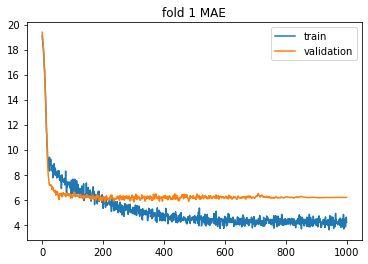

Train MAE = 3.614 for fold 2
Validation MAE = 4.783 for fold 2


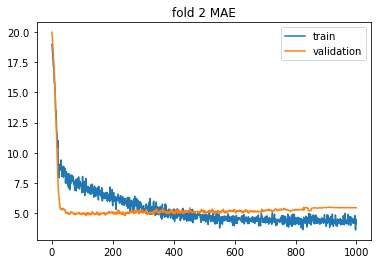

Train MAE = 3.677 for fold 3
Validation MAE = 4.906 for fold 3


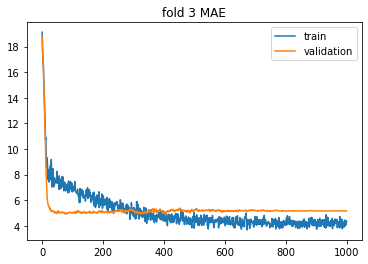

Train MAE = 3.469 for fold 4
Validation MAE = 5.086 for fold 4


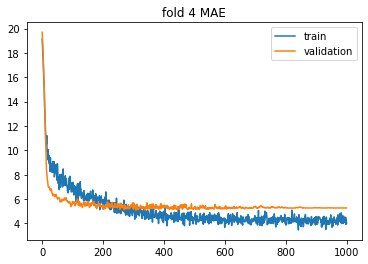

Train MAE = 3.874 for fold 5
Validation MAE = 6.215 for fold 5


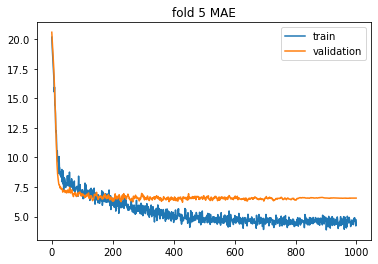

In [4]:
import seaborn as sns

for fold in range(num_folds):
    plt.title('fold %d MAE' %(fold+1))
    print('Train MAE = %.3f for fold %d' %( np.min(allmae_train[str(fold)]) , fold+1))
    print('Validation MAE = %.3f for fold %d' %( np.min(allmae_val[str(fold)]) , fold+1))
    plt.plot(allmae_train[str(fold)],label='train')
    plt.plot(allmae_val[str(fold)],label='validation')
    plt.legend()
    plt.show()

Training MAE = 5.276
Validation MAE = 5.874
Test MAE = 4.118


/nasdata/KHJ/.conda/envs/asd_ai/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


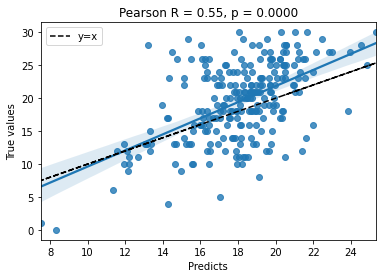

In [5]:
for fold in range(num_folds):
    if fold == 0:
        allpreds_array = allpreds[str(fold)]
        alltrues_array = ally_true[str(fold)]
        allmae_val_array = allmae_val[str(fold)]
        allmae_train_array = allmae_train[str(fold)]
    else:
        allpreds_array = np.append(allpreds_array,allpreds[str(fold)])
        alltrues_array = np.append(alltrues_array,ally_true[str(fold)])
        allmae_val_array = np.append(allmae_val_array,allmae_val[str(fold)])
        allmae_train_array = np.append(allmae_train_array,allmae_train[str(fold)])
        
print('Training MAE = %.3f' %(np.mean(allmae_train_array)))
print('Validation MAE = %.3f' %(np.mean(allmae_val_array)))
print('Test MAE = %.3f' %( mae(allpreds_array,alltrues_array)))

sns.regplot(allpreds_array,alltrues_array)
plt.plot(allpreds_array,allpreds_array,'k--',label='y=x')
r, p = pearsonr(allpreds_array,alltrues_array)
plt.xlabel('Predicts')
plt.ylabel('True values')
plt.title('Pearson R = %0.2f, p = %0.4f' % ( r,p) )
plt.legend()
plt.show()
        

In [6]:
p

6.640431506757986e-21

In [7]:
r

0.5487677878157194